In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

font = {'size'   : 12}

matplotlib.rc('font', **font)

In [2]:
create_time = pd.read_csv("../results_remote/FAST_KNN_NO_ObjIndex_L9_lazy_search_sub_timeline_2500000_100000.csv", names=['obj_search', 'insert', 'ar', 'des_count', 'level']).reset_index()
create_time['name'] = 'fast'
create_time['obj_search'] = create_time['obj_search'] / 1000000
create_time['insert'] = create_time['insert'] / 1000000
create_time = create_time.melt(id_vars=['index', 'name', 'ar', 'des_count', 'level'], var_name='stage', value_name='time')

create_time

,index,name,ar,des_count,level,stage,time
0,0,fast,1.797693e+308,0,9,obj_search,0.000000
1,1,fast,1.797693e+308,0,9,obj_search,0.000000
2,2,fast,1.797693e+308,0,9,obj_search,0.000000
3,3,fast,1.797693e+308,0,9,obj_search,0.000000
4,4,fast,1.797693e+308,0,9,obj_search,0.000000
...,...,...,...,...,...,...,...
12199995,2499995,fast,1.797693e+308,0,9,insert,0.001322
12199996,2499996,fast,1.797693e+308,0,9,insert,0.001134
12199997,2499997,fast,1.797693e+308,0,9,insert,0.004097
12199998,2499998,fast,1.797693e+308,0,9,insert,0.002391


## Creation time

(0.0, 10.0)

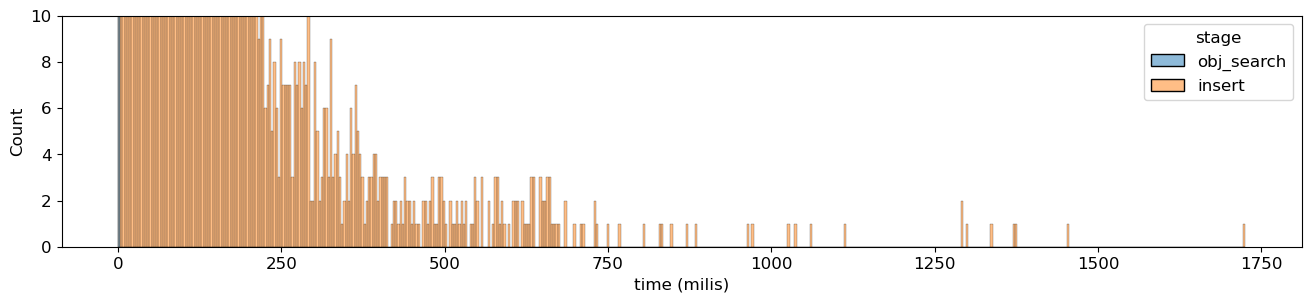

In [3]:
plt.figure(figsize=(16,3))
sns.histplot(x='time', bins=500, hue='stage', multiple='layer', data=create_time)
plt.xlabel('time (milis)')
plt.ylim(0, 10)

**Miserable queries**

Queries that takes too much time (>100 milis). 

In [4]:
miserable_queries = create_time[create_time['time'] > 5].sort_values('time', ascending=False)
miserable_queries

,index,name,ar,des_count,level,stage,time
9590209,1890209,fast,1.797693e+308,0,9,insert,1725.356371
11639777,1939777,fast,1.069274e+02,1,8,insert,1455.977822
9223410,1523410,fast,1.908000e+02,1,8,insert,1374.976940
12118585,2418585,fast,1.209685e+02,1,8,insert,1371.853500
11295447,1595447,fast,9.226330e+01,1,8,insert,1335.989332
...,...,...,...,...,...,...,...
6377730,177730,fast,3.103181e-01,1,8,insert,5.001232
9949112,249112,fast,9.023200e+00,0,9,insert,5.000947
10776734,1076734,fast,3.823739e+00,1,8,insert,5.000710
10477913,777913,fast,4.275239e+01,1,8,insert,5.000591


In [ ]:
# step = 500000
# for i in range(0, 2500000, step):
plt.figure(figsize=(16,3))
sns.lineplot(x='index', y='time', hue='stage', style='stage', data=create_time)
plt.xlabel('timestamp')
plt.ylabel('time (milis)')
plt.ylim(0, 150)

Relative time (FAST vs CkQST)

In [ ]:
# relative_create = create_time[create_time['stage'] == 'insert']['time'].reset_index() - create_time[create_time['stage'] == 'obj_search']['time'].reset_index()
# relative_create
# plt.figure(figsize=(16,8))
# sns.lineplot(data=relative_create)
# plt.xlabel('timestamp')
# plt.ylabel('time (milis)')

## Load Queries

In [ ]:
queries_df = pd.read_json('../../data/exported/places_o200000_q2500000_scaled.json', lines=True);
queries_df = queries_df.iloc[200000:, :].reset_index(drop=True).drop(columns=['id']).reset_index()

queries_df.tail()

### Properties of miserable queries

In [ ]:
queries_df.shape

In [ ]:
details = queries_df.join(miserable_queries.set_index('index'), on='index').dropna().sort_values('time', ascending=False)
# details = details[details['name'] == 'fast']
inf_val = details['ar'].max()
details['ar'] = details['ar'].apply(lambda x: np.inf if x >= inf_val else x)
all = details.drop(columns=['x', 'y']).rename(columns={'time': 'insertion time (milis)'})

In [ ]:
obj_search = all[all['stage'] == 'obj_search']
insert = all[all['stage'] == 'insert']

# insert#.join(ckqsts, rsuffix='_')
insert.head(25)
# all.head(25)

In [ ]:
obj_search.head(25)

## Query size vs Insertion time

In [ ]:
stats = create_time.copy()
stats = queries_df.join(stats.set_index('index'), on='index').dropna()

In [ ]:
stats['n_keywords'] = stats['keywords'].apply(lambda x: min(len(x), 5))

### Query index insert

In [ ]:
insert_only = pd.DataFrame(stats[stats['stage'] == 'insert'])
insert_only['ar'] = insert_only['ar'].apply(lambda x: 512 if x > 512 else x)

sns.scatterplot(y='time', x='ar', data=insert_only.loc[:, ['ar', 'time']])

In [ ]:
sns.scatterplot(y='time', x='n_keywords', data=insert_only.loc[:, ['n_keywords', 'time']])

In [ ]:
sns.scatterplot(y='time', x='des_count', data=insert_only.loc[:, ['des_count', 'time']])

In [ ]:
sns.scatterplot(y='time', x='level', data=insert_only.loc[:, ['level', 'time']])

In [ ]:
out = insert_only.loc[:, ['level', 'time']]

In [ ]:
sns.histplot(out['level'])

In [ ]:
sns.histplot(out['level'])
plt.ylim(0, 15000)

In [ ]:
hist_out = out.groupby('level').mean().reset_index()
sns.barplot(x='level', y='time', data=hist_out)
plt.ylabel('avg. insert time (query index - fast)')

### Obj index search

In [ ]:
search_only = pd.DataFrame(stats[stats['stage'] == 'obj_search'])
search_only['ar'] = search_only['ar'].apply(lambda x: 512 if x > 512 else x)

sns.scatterplot(y='time', x='ar', data=search_only.loc[:, ['ar', 'time']])

In [ ]:
sns.scatterplot(y='time', x='n_keywords', data=search_only.loc[:, ['n_keywords', 'time']])

In [ ]:
sns.scatterplot(y='time', x='des_count', data=search_only.loc[:, ['des_count', 'time']])

In [ ]:
sns.scatterplot(y='time', x='level', data=search_only.loc[:, ['level', 'time']])